In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import statsmodels.nonparametric.smoothers_lowess as lowess
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import LSQUnivariateSpline
from sklearn.metrics import r2_score
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
data = pd.read_csv("data.csv")

# Set the dates as index
data = data.set_index("Month")
data.head()

# Change column name
data.columns = ["Monthly Aggregates of RBC units"]
data.head()

# Train and testing data
train = data.iloc[:int(len(data)*0.8)].copy()
test = data.iloc[int(len(data)*0.8):].copy()

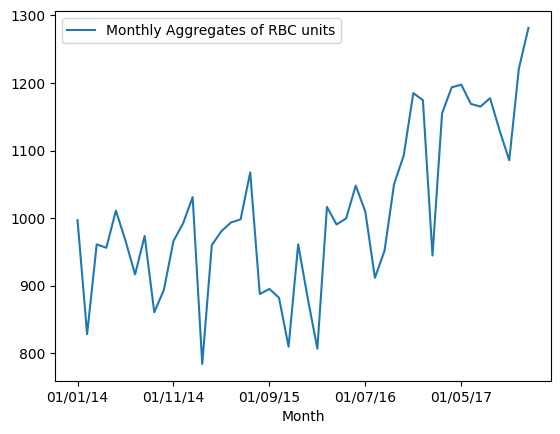

In [ ]:
# Plot train
train.plot()
# Set
plt.show()

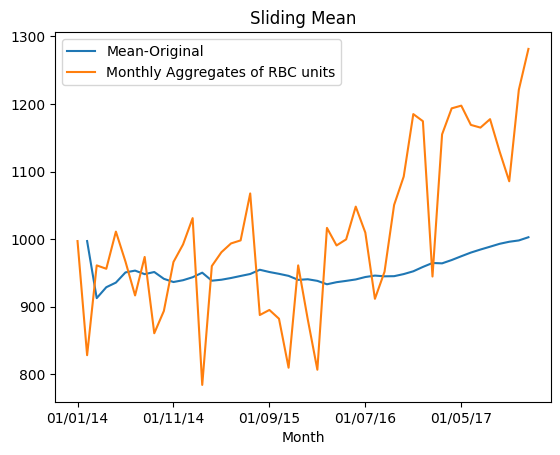

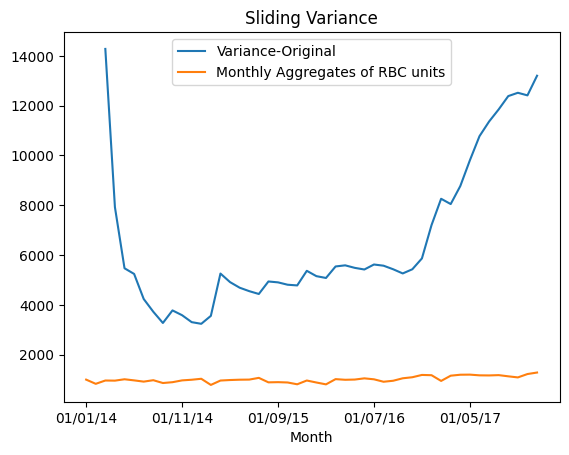

In [ ]:
# Review the sliding mean and variance plots
def mean_var(col):
  mean_plt = []
  var_plt = []
  for i in range(0, len(train)):
      mean_plt.append(train[col].iloc[:i].mean())
      var_plt.append(train[col].iloc[:i].var())
  return mean_plt, var_plt

mean_plt, var_plt = mean_var("Monthly Aggregates of RBC units")

# Keep only 5-6 dates in the x axis; don't make plt plot all dates
train["Mean-Original"] = mean_plt
train["Variance-Original"] = var_plt

# Plot
train["Mean-Original"].plot()
train["Monthly Aggregates of RBC units"].plot()
plt.legend()
plt.title("Sliding Mean")
plt.show()

train["Variance-Original"].plot()
train["Monthly Aggregates of RBC units"].plot()
plt.legend()
plt.title("Sliding Variance")
plt.show()

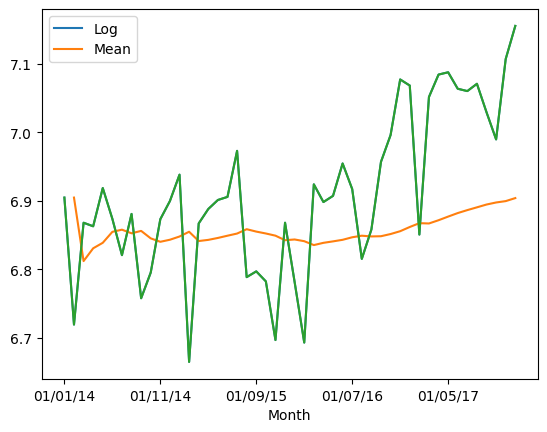

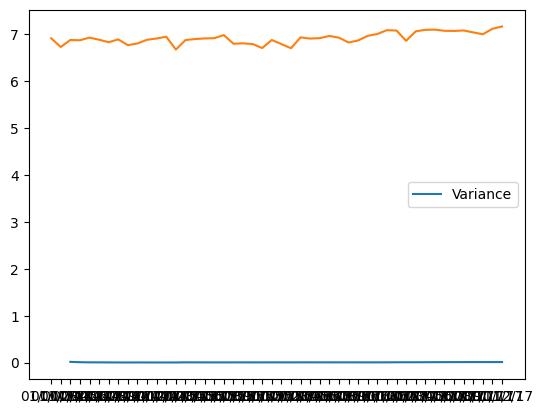

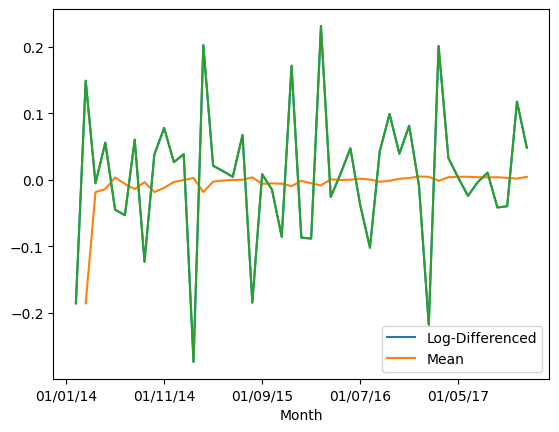

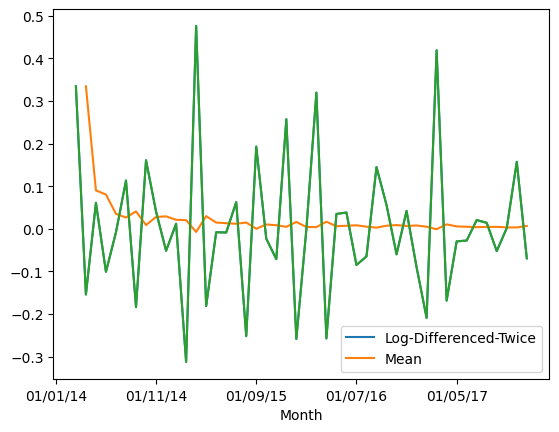

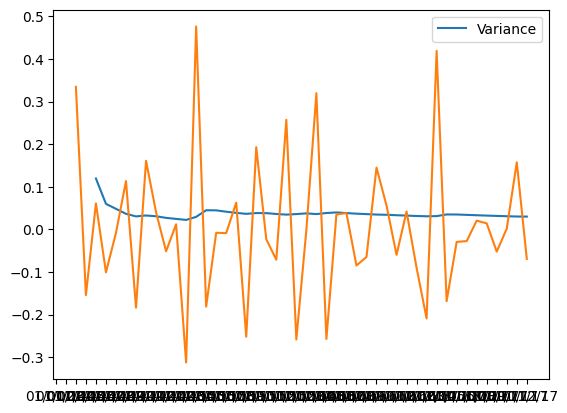

In [ ]:
# Let's deal with the variance first.
train["Log"] = np.log(train["Monthly Aggregates of RBC units"])
train["Log"].plot()

# Review mean once
mean_plt, var_plt = mean_var("Log")

# Plot the mean and variance plots
plt.plot(mean_plt, label="Mean")
plt.plot(train['Log'])
plt.legend()
plt.show()

plt.plot(var_plt, label="Variance")
plt.plot(train['Log'])
plt.legend()
plt.show()

# Let's deal with the mean. Let's transform.

# Let's start with differencing.
train["Log-Differenced"] = train["Log"].diff()

# Plot Differenced
train["Log-Differenced"].plot()

# Review mean once
mean_plt, var_plt = mean_var("Log-Differenced")

# Plot the mean and variance plots
plt.plot(mean_plt, label="Mean")
plt.plot(train['Log-Differenced'])
plt.legend()
plt.show()

# Double difference.
train["Log-Differenced-Twice"] = train["Log-Differenced"].diff()

# Plot Differenced
train["Log-Differenced-Twice"].plot()

# Review mean once.
mean_plt, var_plt = mean_var("Log-Differenced-Twice")

# Plot mean.
plt.plot(mean_plt, label="Mean")
plt.plot(train['Log-Differenced-Twice'])
plt.legend()
plt.show()

plt.plot(var_plt, label="Variance")
plt.plot(train['Log-Differenced-Twice'])
plt.legend()
plt.show()

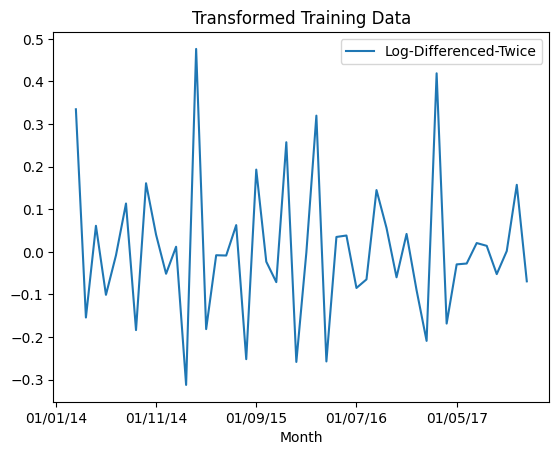

In [ ]:
# Plot Log-Differenced-Twice
train["Log-Differenced-Twice"].plot()
plt.legend()
plt.title("Transformed Training Data")
plt.show()

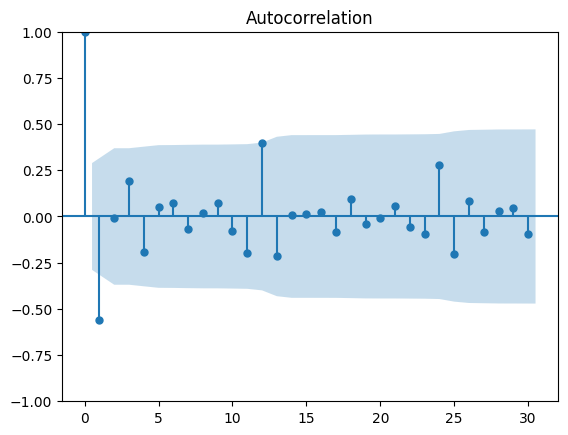

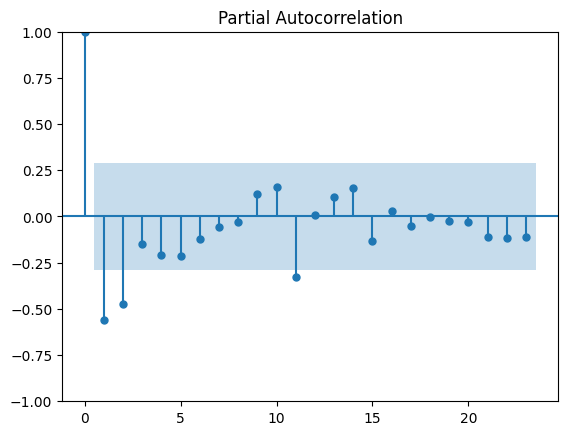

(-3.6442387261238975,
 0.004969471818779986,
 10,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 -55.49755811424555)

In [ ]:
# Remove NaNs and -inf, inf
train = train.dropna()
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna()

# Plot ACF, PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train["Log-Differenced-Twice"], lags=30)
plot_pacf(train["Log-Differenced-Twice"], lags=23)
plt.show()

# Test ADF.
from statsmodels.tsa.stattools import adfuller
adfuller(train["Log-Differenced-Twice"])

In [ ]:
# Fit regression
# Start with linear, polynomial, spline, lowess, loess and more
from sklearn.metrics import r2_score
# Print BIC and R2 scores with each model

import statsmodels.api as sm
import statsmodels.nonparametric.smoothers_lowess as lowess

t = np.arange(1, len(train["Monthly Aggregates of RBC units"]) + 1)

# Linear
model = sm.OLS(train["Monthly Aggregates of RBC units"], sm.add_constant(t)).fit()
print("Linear")
print("BIC: ", model.bic)
print("R2: ", r2_score(train["Monthly Aggregates of RBC units"], model.predict()))
print("MAE: ", np.mean(np.abs(model.predict() - train["Monthly Aggregates of RBC units"])))
# Print MAE for testing data
# Predict for testing data
# Predicting on test data (assuming 'test' also has the same time structure)
t_test = np.arange(len(train["Monthly Aggregates of RBC units"]) + 1, len(train["Monthly Aggregates of RBC units"]) + len(test["Monthly Aggregates of RBC units"]) + 1)

# Predictions for the test set
test_predictions = model.predict(sm.add_constant(t_test))
print("MAE for Testing Data: ", np.mean(np.abs(test_predictions - test["Monthly Aggregates of RBC units"])))

# Plot the original
plt.plot(train["Monthly Aggregates of RBC units"])
plt.plot(model.predict(), label="Linear")
plt.legend()
plt.show()

# Difference and review if stationary
train["LinearRegression-Differenced"] = train["Monthly Aggregates of RBC units"] - model.predict()
print(adfuller(train["LinearRegression-Differenced"]))

# Plot the differenced
plt.plot(train["LinearRegression-Differenced"])
plt.show()

Polynomial
BIC (Train):  562.7172665505527
R2 (Train):  0.5681414315379092
R2 (Test):  -0.9733691672617064
MAE (Train):  65.47359392743793
MAE (Test):  111.94748896442673


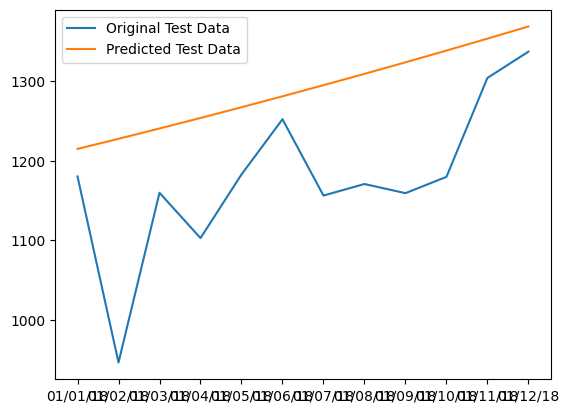

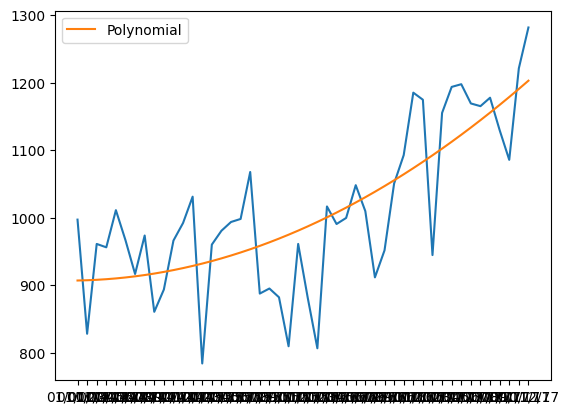

(-5.399082790558373, 3.4022612934908676e-06, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 433.08582145571467)


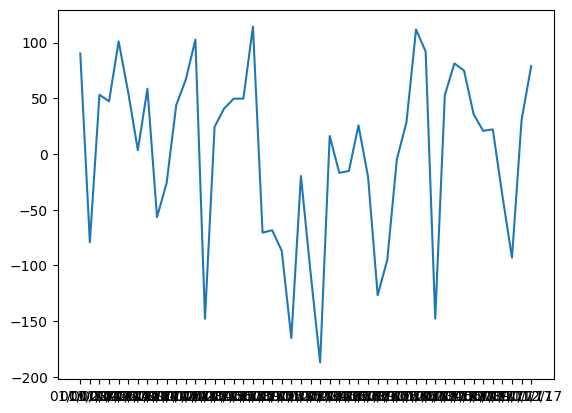

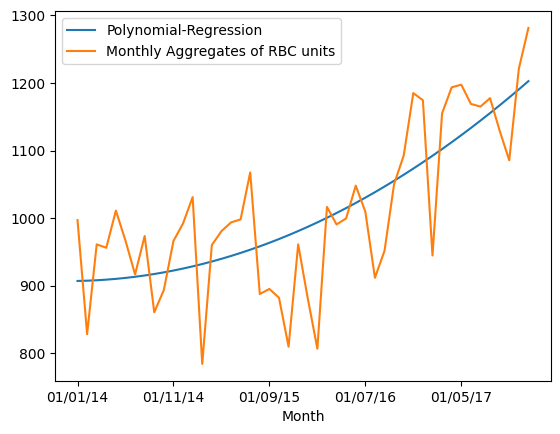

In [ ]:
# Polynomial Regression
from sklearn.metrics import r2_score
# Print BIC and R2 scores with each model

import statsmodels.api as sm
import statsmodels.nonparametric.smoothers_lowess as lowess
# Time variable for the training set
t_train = np.arange(1, len(train["Monthly Aggregates of RBC units"]) + 1)

# Fit a polynomial model (quadratic)
model_poly = sm.OLS(train["Monthly Aggregates of RBC units"], sm.add_constant(np.power(t_train, 2))).fit()

# Time variable for the test set
t_test = np.arange(len(train["Monthly Aggregates of RBC units"]) + 1, len(train["Monthly Aggregates of RBC units"]) + len(test["Monthly Aggregates of RBC units"]) + 1)

# Predicting on the test data (for polynomial model)
test_predictions_poly = model_poly.predict(sm.add_constant(np.power(t_test, 2)))

# Calculate R², MAE for the test data
print("Polynomial")
print("BIC (Train): ", model_poly.bic)  # BIC for the training model
print("R2 (Train): ", r2_score(train["Monthly Aggregates of RBC units"], model_poly.predict(sm.add_constant(np.power(t_train, 2)))))
print("R2 (Test): ", r2_score(test["Monthly Aggregates of RBC units"], test_predictions_poly))
print("MAE (Train): ", np.mean(np.abs(model_poly.predict(sm.add_constant(np.power(t_train, 2))) - train["Monthly Aggregates of RBC units"])))
print("MAE (Test): ", np.mean(np.abs(test_predictions_poly - test["Monthly Aggregates of RBC units"])))

# Plot the test_predictions_poly and
plt.plot(test["Monthly Aggregates of RBC units"], label="Original Test Data")
plt.plot(test_predictions_poly, label="Predicted Test Data")
plt.legend()
plt.show()


"""
Make a table in Latex for model | MAE in Training Data | MAE in Testing Data
Linear: 72.71551523978378, 59.9969815940561
Polynomial: 65.47359392743793, 111.94748896442673
Multivariate Spline: 55.20243176286423, 331.94787526780925
SARIMAX(2, 2, 1) x (0, 0, 2, 12): 69.19337922487581, 133.45075597155827
SARIMA(0, 1, 1)x(2, 1, 0, 12): 65.92000779817499
"""
# Plot
plt.plot(train["Monthly Aggregates of RBC units"])
plt.plot(model_poly.predict(), label="Polynomial")
plt.legend()
plt.show()

# Difference and review stationary
train["PolynomialRegression-Differenced"] = train["Monthly Aggregates of RBC units"] - model_poly.predict()
print(adfuller(train["PolynomialRegression-Differenced"]))

# Plot
plt.plot(train["PolynomialRegression-Differenced"])
plt.show()

train["Polynomial-Regression"] = model_poly.predict()
#Plot
train["Polynomial-Regression"].plot()
train["Monthly Aggregates of RBC units"].plot()
plt.legend()
plt.show()

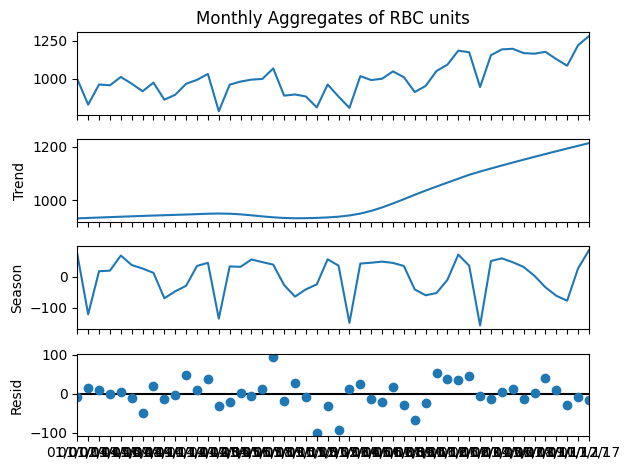

(-6.405104022164008, 1.952041495804261e-08, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 427.89465620117085)


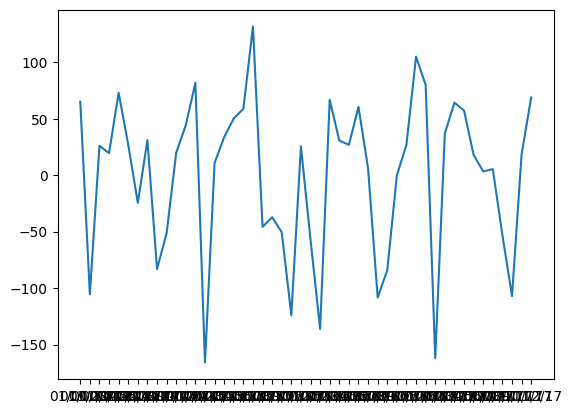

R2:  0.6485079754646641
MAE:  57.700391920200474


In [ ]:
# LOESS
from statsmodels.tsa.seasonal import STL

model_loess = STL(train["Monthly Aggregates of RBC units"], period=12)
results = model_loess.fit()
results.plot()
plt.show()

# Difference and review if stationary
train["LOESS-Differenced"] = train["Monthly Aggregates of RBC units"] - results.trend
print(adfuller(train["LOESS-Differenced"]))

# Plot
plt.plot(train["LOESS-Differenced"])
plt.show()

# Review R2 and BIC scores
print("R2: ", r2_score(train["Monthly Aggregates of RBC units"], results.trend))
print("MAE: ", np.mean(np.abs(results.trend - train["Monthly Aggregates of RBC units"])))

# print("BIC: ", model_loess.fit().bic)

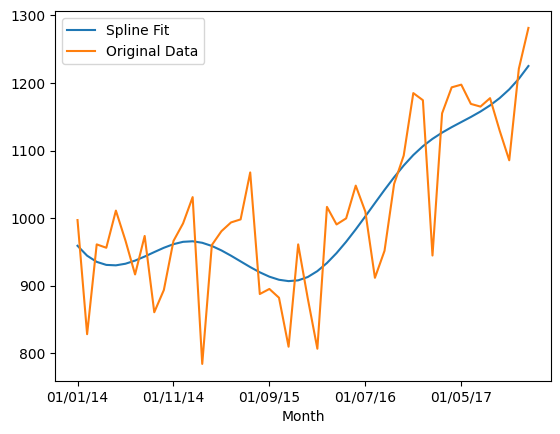

Spline
R2 (Train):  0.6604651279817426
R2 (Test):  -14.101277516065
MAE (Train):  55.20243176286423
MAE (Test):  331.94787526780925


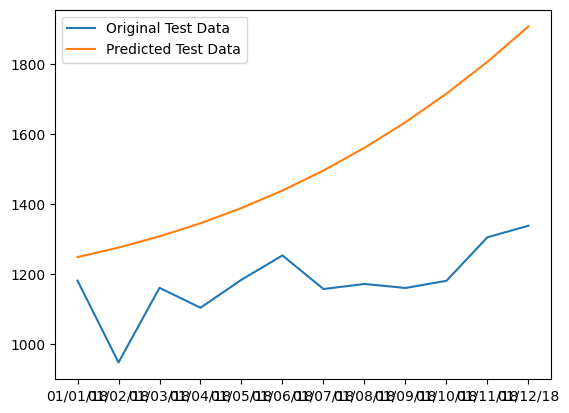

In [ ]:
# Time variable for the training set
t_train = np.arange(1, len(train["Monthly Aggregates of RBC units"]) + 1)

# Define knots for the spline (25th, 50th, 75th percentiles)
knots = np.percentile(t_train, [25, 50, 75])

# Fit a cubic spline to the training data
spline = LSQUnivariateSpline(t_train, train["Monthly Aggregates of RBC units"], t=knots, k=3)

# Generate spline predictions for training data
train['Multivariate-Spline'] = spline(t_train)

# Plot the results
train["Multivariate-Spline"].plot(label='Spline Fit')
train["Monthly Aggregates of RBC units"].plot(label='Original Data')
plt.legend()
plt.show()

# Time variable for the test set (continued after training set)
t_test = np.arange(len(train["Monthly Aggregates of RBC units"]) + 1, len(train["Monthly Aggregates of RBC units"]) + len(test["Monthly Aggregates of RBC units"]) + 1)

# Predict on the test data using the spline model
test_predictions_spline = spline(t_test)

# Calculate R² and MAE for the test data
print("Spline")
print("R2 (Train): ", r2_score(train["Monthly Aggregates of RBC units"], train["Multivariate-Spline"]))
print("R2 (Test): ", r2_score(test["Monthly Aggregates of RBC units"], test_predictions_spline))
print("MAE (Train): ", np.mean(np.abs(train["Multivariate-Spline"] - train["Monthly Aggregates of RBC units"])))
print("MAE (Test): ", np.mean(np.abs(test_predictions_spline - test["Monthly Aggregates of RBC units"])))

# Plot the test_predictions
plt.plot(test["Monthly Aggregates of RBC units"], label="Original Test Data")
plt.plot(test_predictions_spline, label="Predicted Test Data")
plt.legend()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Try out different models.
def evaluate_models(p, d, q, P, D, Q, s, train):
  # p, d, q, P, D, Q, s are all lists
  for p_val in p:
    for d_val in d:
      for q_val in q:
        for P_val in P:
          for D_val in D:
            for Q_val in Q:
              for s_val in s:
                model = SARIMAX(train, order=(p_val, d_val, q_val), seasonal_order=(P_val, D_val, Q_val, s_val))
                model_fit = model.fit()

                # Print AIC, BIC values
                print(f"[MODEL -- SARIMAX({p_val}, {d_val}, {q_val}) x ({P_val}, {D_val}, {Q_val}, {s_val})] AIC: {model_fit.aic}, BIC: {model_fit.bic}, R2: {r2_score(train[d_val:], model_fit.fittedvalues[d_val:])}")


evaluate_models([1, 2, 3], [2], [0, 1, 2], [0], [0], [0, 1, 2], [12], train["Monthly Aggregates of RBC units"])

[MODEL -- SARIMAX(1, 2, 0) x (0, 0, 0, 12)] AIC: 557.0220613399215, BIC: 560.5904406077581, R2: -0.1417298623521137
[MODEL -- SARIMAX(1, 2, 0) x (0, 0, 1, 12)] AIC: 553.4810621195414, BIC: 558.8336310212962, R2: -0.008484344836659607
[MODEL -- SARIMAX(1, 2, 0) x (0, 0, 2, 12)] AIC: 553.7749114622364, BIC: 560.9116699979095, R2: 0.028313077241862605
[MODEL -- SARIMAX(1, 2, 1) x (0, 0, 0, 12)] AIC: 531.820444048192, BIC: 537.1730129499468, R2: 0.39912864220115896
[MODEL -- SARIMAX(1, 2, 1) x (0, 0, 1, 12)] AIC: 528.095008855072, BIC: 535.2317673907451, R2: 0.46888006715425445
[MODEL -- SARIMAX(1, 2, 1) x (0, 0, 2, 12)] AIC: 526.4934925154406, BIC: 535.4144406850319, R2: 0.5056562622522021
[MODEL -- SARIMAX(1, 2, 2) x (0, 0, 0, 12)] AIC: 526.4176135460201, BIC: 533.5543720816931, R2: 0.49942791163173716
[MODEL -- SARIMAX(1, 2, 2) x (0, 0, 1, 12)] AIC: 524.778796251016, BIC: 533.6997444206073, R2: 0.534734064920749
[MODEL -- SARIMAX(1, 2, 2) x (0, 0, 2, 12)] AIC: 523.0920423588445, BIC: 53

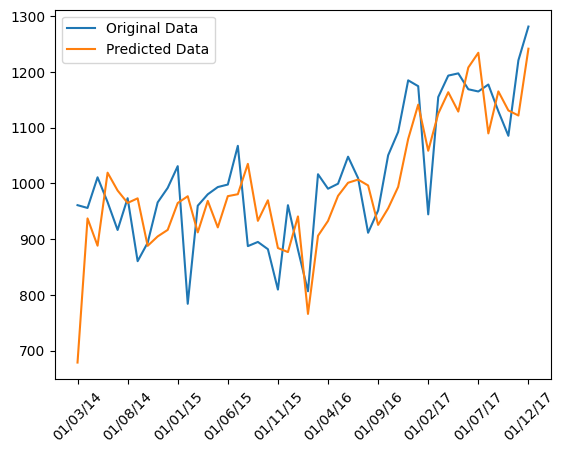

In [ ]:
# Plot some SARIMAX model.
# (2, 2, 1) x (0, 0, 2, 12)
model = SARIMAX(train["Monthly Aggregates of RBC units"], order=(2, 2, 1), seasonal_order=(0, 0, 2, 12))
model_fit = model.fit()

# Plot original data and predicted from [2:]
plt.plot(train.index[2:], train["Monthly Aggregates of RBC units"][2:], label="Original Data")
plt.plot(train.index[2:], model_fit.fittedvalues[2:], label="Predicted Data")
# Select a subset of x-axis labels (e.g., every 5th index)
xticks_interval = 5
plt.xticks(train.index[2::xticks_interval], rotation=45)

# Show the plot
plt.legend()
plt.show()

In [ ]:
# MAE, MSE
mse = np.mean((model_fit.fittedvalues[2:] - train["Monthly Aggregates of RBC units"][2:])[2:]**2)
mae = np.mean(np.abs(model_fit.fittedvalues[2:] - train["Monthly Aggregates of RBC units"][2:]))

print("MSE: ", mse)
print("MAE: ", mae)


MSE:  5829.5778169965815
MAE:  69.19337922487581


In [ ]:
# Plot test and stuff.
# Time variable for the test set (after training data)
# Make predictions for the test set
test_predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
MAE_SUM = 0
for i in range(len(test_predictions)):
  MAE_SUM += abs(test_predictions.iloc[i] - test["Monthly Aggregates of RBC units"][i])
print("MAE: ", MAE_SUM / len(test_predictions))


MAE:  133.45075597155827


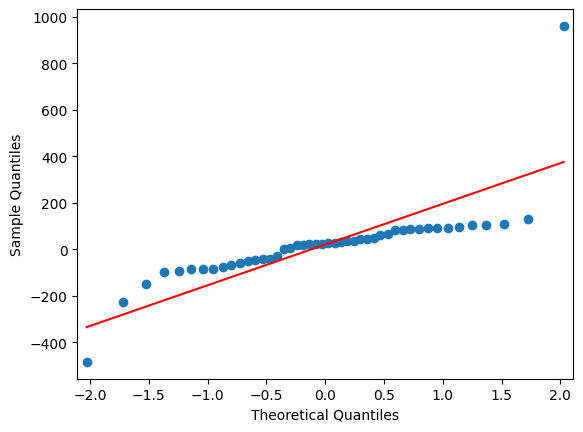

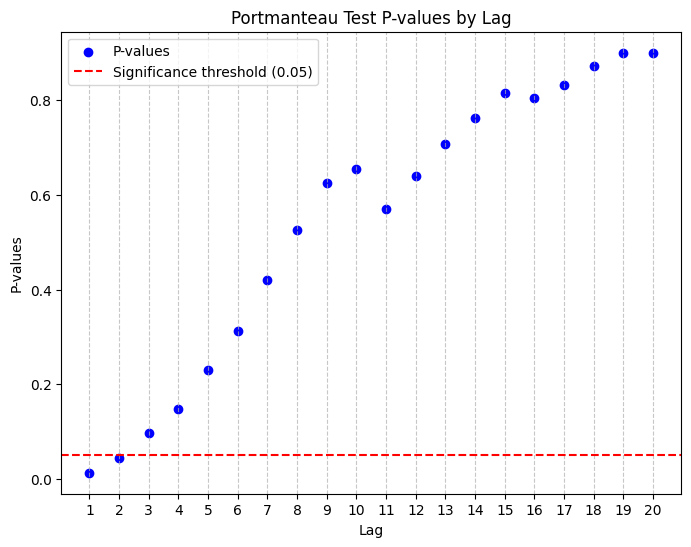

In [ ]:
# Portmanteau test.
# Do Q-Q plot for residual.
qqplot(model_fit.resid, line='s')
plt.show()

# Portmanteau test.
def portmanteau_test(residue):
  p_vals = []
  lags = []
  for i in range(1, 21):
    lags.append(i)
    p_vals.append(acorr_ljungbox(residue, lags=[i]).lb_pvalue)

  plt.figure(figsize=(8, 6))
  plt.scatter(lags, p_vals, color='blue', label='P-values')
  plt.axhline(y=0.05, color='red', linestyle='--', label='Significance threshold (0.05)')

  # Adding labels and title
  plt.xlabel("Lag")
  plt.ylabel("P-values")
  plt.xticks(lags)  # Ensure x-axis has integers from 1 to 20
  plt.title("Portmanteau Test P-values by Lag")
  plt.legend()
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.show()

portmanteau_test(model_fit.resid)

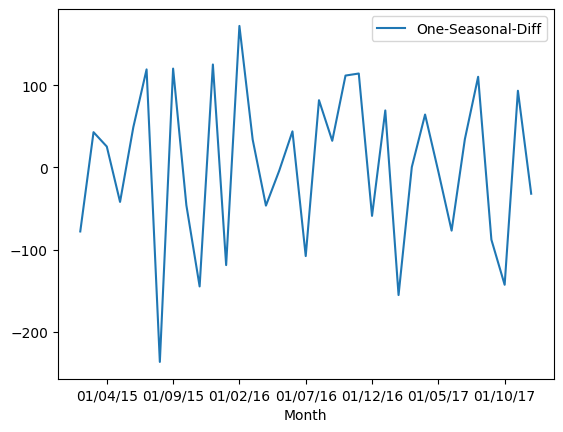

(-8.861760649611822,
 1.4763784694835418e-14,
 0,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 284.71632823215987)

In [ ]:
# One-diff.
train["One-Diff"] = train["Monthly Aggregates of RBC units"].diff()

# One-seasonal diff.
train["One-Seasonal-Diff"] = train["One-Diff"].diff(12)

# Plot and check ADF.
train["One-Seasonal-Diff"].plot()
plt.legend()
plt.show()

# Remove NaNs.
train = train.dropna()
adfuller(train["One-Seasonal-Diff"])

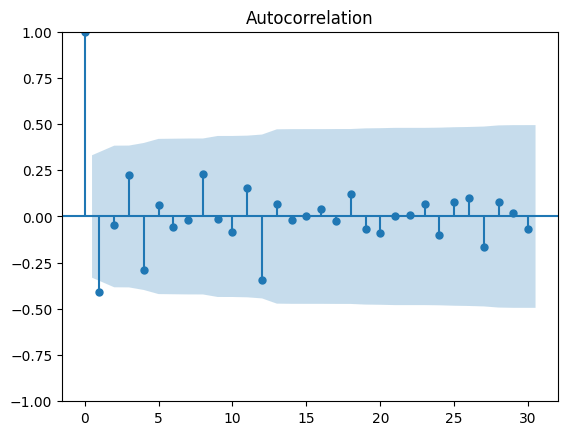

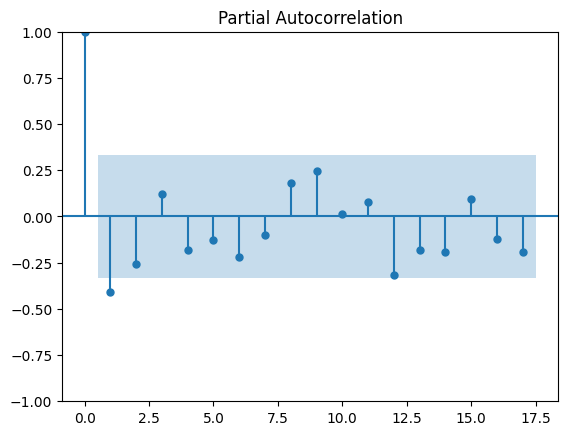

In [ ]:
# ACF, PACF.
plot_acf(train["One-Seasonal-Diff"], lags=30)
plot_pacf(train["One-Seasonal-Diff"], lags=17)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Try out different models.
def evaluate_models(p, d, q, P, D, Q, s, train):
  # p, d, q, P, D, Q, s are all lists
  for p_val in p:
    for d_val in d:
      for q_val in q:
        for P_val in P:
          for D_val in D:
            for Q_val in Q:
              for s_val in s:
                model = SARIMAX(train, order=(p_val, d_val, q_val), seasonal_order=(P_val, D_val, Q_val, s_val))
                model_fit = model.fit()

                # Print AIC, BIC values
                print(f"[MODEL -- SARIMAX({p_val}, {d_val}, {q_val}) x ({P_val}, {D_val}, {Q_val}, {s_val})] AIC: {model_fit.aic}, BIC: {model_fit.bic})}")


evaluate_models([0, 1, 2], [1], [0, 1, 2], [0, 1, 2], [1], [0, 1, 2], [12], train["Monthly Aggregates of RBC units"])

[MODEL -- SARIMAX(0, 1, 0) x (0, 1, 0, 12)] AIC: 421.07884649213236, BIC: 422.6341945536218, R2: 0.09784151241534034
[MODEL -- SARIMAX(0, 1, 0) x (0, 1, 1, 12)] AIC: 409.58247650625094, BIC: 412.69317262922976, R2: 0.23085667385478803
[MODEL -- SARIMAX(0, 1, 0) x (0, 1, 2, 12)] AIC: 408.4788473613257, BIC: 413.14489154579394, R2: 0.2343986635867168
[MODEL -- SARIMAX(0, 1, 0) x (1, 1, 0, 12)] AIC: 415.14967337807855, BIC: 418.26036950105737, R2: 0.17801457045653402
[MODEL -- SARIMAX(0, 1, 0) x (1, 1, 1, 12)] AIC: 410.22210165500394, BIC: 414.8881458394722, R2: 0.2292644166501263
[MODEL -- SARIMAX(0, 1, 0) x (1, 1, 2, 12)] AIC: 410.41495698425507, BIC: 416.6363492302127, R2: 0.23638048821058022
[MODEL -- SARIMAX(0, 1, 0) x (2, 1, 0, 12)] AIC: 405.1261874258723, BIC: 409.79223161034054, R2: 0.25189724536722713
[MODEL -- SARIMAX(0, 1, 0) x (2, 1, 1, 12)] AIC: 407.1127727424219, BIC: 413.33416498837954, R2: 0.2519482642541061
[MODEL -- SARIMAX(0, 1, 0) x (2, 1, 2, 12)] AIC: 409.128345749929

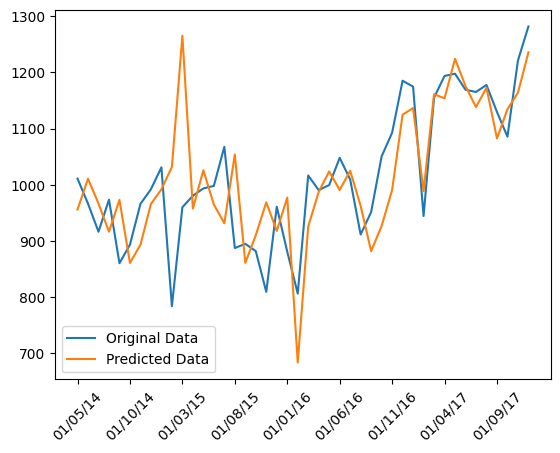

In [ ]:
# SARIMA(0, 1, 1)x(2, 1, 0, 12)
model = SARIMAX(train["Monthly Aggregates of RBC units"], order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit()

# Plot.
plt.plot(train["Monthly Aggregates of RBC units"][2:], label="Original Data")
plt.plot(model_fit.fittedvalues[2:], label="Predicted Data")

xticks_interval = 5
plt.xticks(train.index[2::xticks_interval], rotation=45)

# Show the plot
plt.legend()
plt.show()

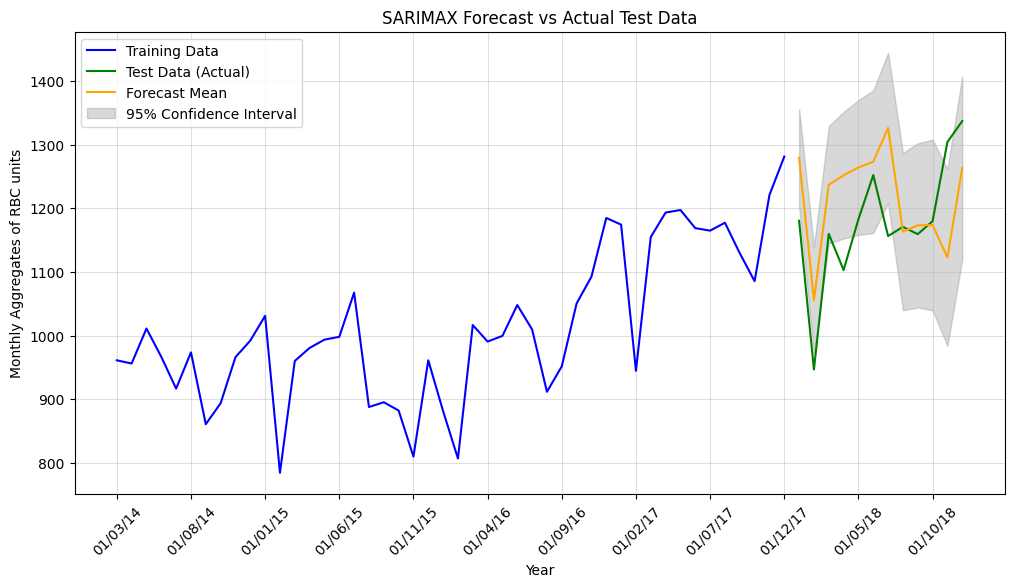

In [ ]:
# Generate forecast
forecast = model_fit.get_forecast(steps=len(test))  # Forecast for the length of the test set
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot historical data (training set), test data, and forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(train.index, train["Monthly Aggregates of RBC units"], label="Training Data", color="blue")

# Plot test data
plt.plot(test.index, test["Monthly Aggregates of RBC units"], label="Test Data (Actual)", color="green")

# Plot forecast mean
plt.plot(forecast_mean.index, forecast_mean, label="Forecast Mean", color="orange")

# Plot confidence interval
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval"
)

# Select a subset of x-axis labels (e.g., every 5th index)
xticks_interval = 5
plt.xticks(data.index[2::xticks_interval], rotation=45)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Monthly Aggregates of RBC units")
plt.title("SARIMAX Forecast vs Actual Test Data")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [ ]:
# Plot test and stuff.
# Time variable for the test set (after training data)
# Make predictions for the test set
test_predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
MAE_SUM = 0
for i in range(len(test_predictions)):
  MAE_SUM += abs(test_predictions.iloc[i] - test["Monthly Aggregates of RBC units"][i])
print("MAE: ", MAE_SUM / len(test_predictions))


MAE:  81.47485672362455


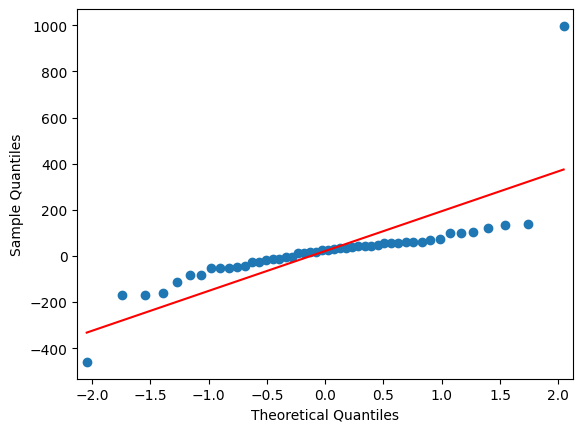

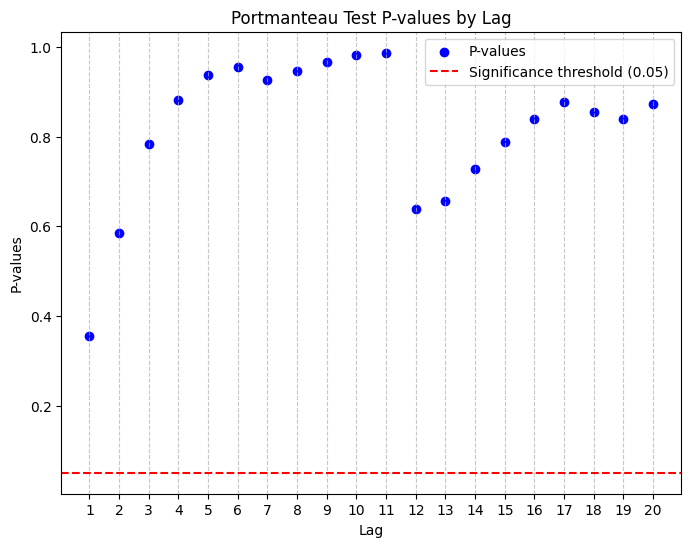

In [ ]:
# Do Q-Q plot for residual.
qqplot(model_fit.resid, line='s')
plt.show()

# Portmanteau test.
def portmanteau_test(residue):
  p_vals = []
  lags = []
  for i in range(1, 21):
    p_vals.append(acorr_ljungbox(residue, lags=[i]).lb_pvalue)
    lags.append(i)

  plt.figure(figsize=(8, 6))
  plt.scatter(lags, p_vals, color='blue', label='P-values')
  plt.axhline(y=0.05, color='red', linestyle='--', label='Significance threshold (0.05)')

  # Adding labels and title
  plt.xlabel("Lag")
  plt.ylabel("P-values")
  plt.xticks(lags)  # Ensure x-axis has integers from 1 to 20
  plt.title("Portmanteau Test P-values by Lag")
  plt.legend()
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.show()

portmanteau_test(model_fit.resid)

In [ ]:
# MSE and MAE from SARIMA
mse = np.mean((model_fit.fittedvalues[2:] - train["Monthly Aggregates of RBC units"][2:])[2:]**2)
mae = np.mean(np.abs(model_fit.fittedvalues[2:] - train["Monthly Aggregates of RBC units"][2:]))

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  9445.732890127636
MAE:  65.92000779817499


Decision Tree MAE in Training Data: 18.78514492753623


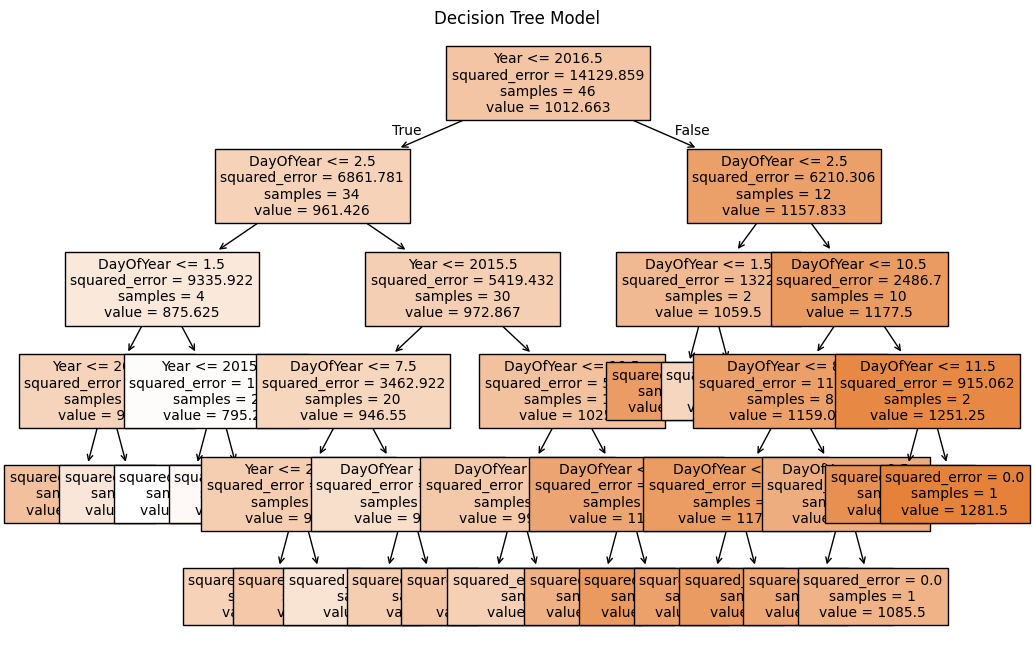

Decision Tree MAE in Testing Data: 38.541666666666664


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn import tree

# Ensure that 'train' has DateTime index
train['Date'] = pd.to_datetime(train.index)

# Extract time-related features from the 'Date' index
train['Month'] = train['Date'].dt.month  # Extract month from the date
train['DayOfYear'] = train['Date'].dt.dayofyear  # Extract day of the year
train['Year'] = train['Date'].dt.year  # Extract the year

# Prepare your features and target
X_train = train[['Month', 'DayOfYear', 'Year']]  # Use the extracted time-related features
y_train = train["Monthly Aggregates of RBC units"]

# Initialize and train the decision tree
dt_model = DecisionTreeRegressor(max_depth=5)  # Adjust max_depth for better interpretability
dt_model.fit(X_train, y_train)

# Predictions
y_train_pred = dt_model.predict(X_train)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"Decision Tree MAE in Training Data: {train_mae}")

# Plot the decision tree
plt.figure(figsize=(12,8))
tree.plot_tree(dt_model, filled=True, feature_names=["Month", "DayOfYear", "Year"], fontsize=10)
plt.title("Decision Tree Model")
plt.savefig("decision_tree.png")

plt.show()

# For Testing Data (if available):
X_test = test[['Month', 'DayOfYear', 'Year']]  # Extract same features for the test set
y_test = test["Monthly Aggregates of RBC units"]

y_test_pred = dt_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Decision Tree MAE in Testing Data: {test_mae}")


Linear Regression Model MAE on Training Data: 19.145186189802846
Linear Regression Model MAE on Testing Data: 116.53678850035908


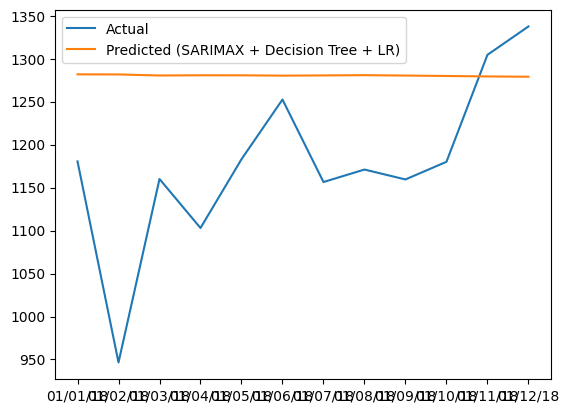

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have your train and test datasets loaded
# train and test are pandas DataFrames with "Monthly Aggregates of RBC units" as the target column

# Step 1: Train the SARIMAX model
sarimax_model = SARIMAX(train["Monthly Aggregates of RBC units"], order=(2, 2, 1), seasonal_order=(0, 0, 2, 12))
sarimax_fit = sarimax_model.fit()

# Step 2: Get SARIMAX predictions for the training data
sarimax_train_pred = sarimax_fit.fittedvalues

# Step 3: Train the Decision Tree model on the same training data
# We will use the time feature (or any other features you want) for the Decision Tree model
X_train = np.arange(1, len(train) + 1).reshape(-1, 1)  # Feature: time (t)
y_train = train["Monthly Aggregates of RBC units"]

dt_model = DecisionTreeRegressor(max_depth=5)
dt_model.fit(X_train, y_train)

# Get Decision Tree predictions for the training data
dt_train_pred = dt_model.predict(X_train)

# Step 4: Combine the predictions from both models (SARIMAX and Decision Tree) using Linear Regression
X_combined_train = np.column_stack([sarimax_train_pred.values, dt_train_pred])  # Stack the predictions

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_combined_train, y_train)

# Step 5: Generate predictions for the test data using both models
# For SARIMAX model
sarimax_test_pred = sarimax_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# For Decision Tree model (same feature as training data: time or other features)
X_test = np.arange(len(train) + 1, len(train) + len(test) + 1).reshape(-1, 1)
dt_test_pred = dt_model.predict(X_test)

# Combine predictions for the test data
X_combined_test = np.column_stack([sarimax_test_pred, dt_test_pred])

# Step 6: Make final predictions using the Linear Regression coefficients
# Linear Regression formula: y_pred = (coef_1 * X1) + (coef_2 * X2) + intercept
final_test_predictions = np.dot(X_combined_test, lr_model.coef_) + lr_model.intercept_

# Step 7: Evaluate the model
train_mae = mean_absolute_error(y_train, lr_model.predict(X_combined_train))
test_mae = mean_absolute_error(test["Monthly Aggregates of RBC units"], final_test_predictions)

print(f"Linear Regression Model MAE on Training Data: {train_mae}")
print(f"Linear Regression Model MAE on Testing Data: {test_mae}")

# Step 8: Plot the results
plt.plot(test.index, test["Monthly Aggregates of RBC units"], label="Actual")
plt.plot(test.index, final_test_predictions, label="Predicted (SARIMAX + Decision Tree + LR)")
plt.legend()
plt.show()
